### This notebook containsfigures that will be used for the August 4th 2016 Janelia undergraduate poster presentation.

In [626]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.stats as stat
import scipy

from activeConn        import activeConnMain as ACM
from activeConn.graphs import plotfit
from activeConn.tools  import *
from IPython           import display

import tensorflow as tf


%matplotlib inline

In [2]:
#Main path
mPath = '/groups/turaga/home/castonguayp/research/activeConn/'

# Functions

In [720]:
def bootstrapSigPref(data,frame, sigVal = 0.05, niters = 1000):
    # Will shuffle visual presentation frames
    # and calculate the STA and integrated cell
    # response. Will return which cells are below
    # the significance value.
    
    nstim = len(frame) #number of stim
    minF  = frame[0]   #first frame
    maxF  = frame[-1]  #last frame
    
    stimRep  = meanSTA(data, frame)[1]
    
    ctrlResp = [None]*niters
    for i in range(niters):
        #Shuffling
        F = np.random.permutation(np.arange(minF,maxF))[:nstim]
        
        #Preference
        ctrlResp[i] = meanSTA(data, F)[1]
    
    ctrlResp = np.dstack(ctrlResp) 
    
    #Repeting for number of iterations for difference
    repResp = np.tile(stimResp,[niters,1,1]).transpose(1,2,0)
    
    #Difference between real response and control
    diff    = ctrlResp - repResp 
    
    # Will calculate which cell has a sig level below sigVal  by counting the 
    # number of time control is bigger than real.
    sigTest     = np.sum( np.dstack([i>0 for i in diff.T]), axis = 2) < sigVal*niters
    sigCell     = np.where(np.sum(sigTest,axis = 1)>0)[0]      # Significant cells
    notSigCells = np.where(np.sum(sigTest,axis = 1)==0)[0] # Not significant cells
    
    return sigCell, notSigCells

def classMetrics(realW,predW,sigTresh):
    #True positives
    truePos  = (predW>sigTresh) & (realW>0)
    nTruePos = np.sum(truePos)

    #False positives
    falsePos  = (predW>sigTresh) & (realW==0)
    nFalsePos = np.sum(falsePos)

    #True negatives
    trueNeg  = (predW<sigTresh) & (realW==0)
    nTrueNeg = np.sum(trueNeg)

    #False negatives
    falseNeg  = (predW<sigTresh) & (realW>0)
    nFalseNeg = np.sum(falseNeg)
    
    #General metrics
    recall     = nTruePos/(nTruePos+nFalseNeg)
    prec       = nTruePos/(nTruePos+nFalsePos)
    negPredVal = nTrueNeg/(nTrueNeg+nFalseNeg)
    acc        = (prec + negPredVal)/2
    
    metrics = {   'truePos'    : nTruePos,   'falsePos'  : nFalsePos,
                  'trueNeg'    : nTrueNeg,   'falseNeg'  : nFalseNeg,
                  'recall'     : recall,     'precision' : prec,
                  'negPredVal' : negPredVal, 'acc'       : acc       }
    
    return metrics  
    

def meanvar(dirPath,name):
    #To calculate the mean and matrices over folds
    files = os.listdir(dirPath)
    files = [file for file in files if name in file] #Taking only files of interest
    mats  = np.dstack([np.load(dirPath+file)[:,:] for file in files]) #loading matrices
    
    Mean  = np.mean(mats,axis = 2)
    Var   =  np.var(mats,axis = 2)
    
    return Mean, Var, mats

def plotClassMat(mat, title, clim = False, norm = False):
    #Plot matrice of classification scores
    
    if norm:
        mat = abs(mat/abs(mat).max())
    
    plt.figure(figsize = (15,10))
    plt.imshow(mat[:,:-1], aspect = 'auto', interpolation = 'None', cmap = 'Greys')
        
    plt.title(title, fontsize = 15)
    plt.ylabel('Stimulated neurons',  fontsize = 12)
    plt.xlabel('Classifying neurons', fontsize = 12)
    plt.colorbar()
    
    if clim:
        plt.clim(clim)

def plotCorrClass(classi,corr,title):
    plt.figure(figsize = (15,10))
    plt.plot(classi,corr, 'x')
        
    plt.title(title, fontsize = 15)
    plt.ylabel('Predicted weights',    fontsize = 12)
    plt.xlabel('Neurons conrrelation', fontsize = 12)

def loadH5py(datasetNo, dPath):
        #Will load datasets and stack them
        
        #Loading data (baseline removed)
        dat   = h5py.File(dPath)

        #Taking only elements related to dataset selected and renaming
        dat = { key: dat[key] for No in datasetNo for key in dat if No in key}

        #Initializing data dictionnary
        data   = {'dataset':[], 'baseline':[], 'stimFrame':[],'stimIdx':[], 'visFrame':[]}
        keyDat = [key for key in dat.keys() if 'dataset' in key]
        
        T = dat[keyDat[0]].shape[1] 
        
        #Stacking or loading elements of dictionnary
        frameSet= 0 #To count frame datasets
        for key in sorted(dat):
            if   'base'  in key: data['baseline' ].append(dat[key][:])
            elif 'data'  in key: data['dataset'  ].append(dat[key][:])  
            elif 'stimF' in key: data['stimFrame'].append(dat[key][:] + T*frameSet); frameSet +=1 
            elif 'Idx'   in key: data['stimIdx'  ].append(dat[key][:].T)
            elif 'visFr' in key: data['visFrame' ].append(dat[key][:])
                
        return data

# V1 optogenetic data

## Classification matrix average

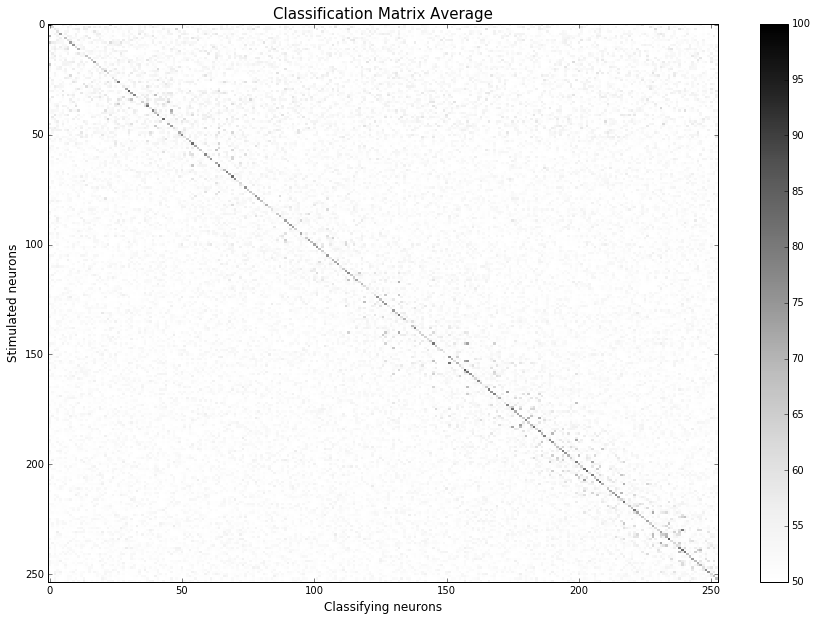

In [4]:
dirV1 = mPath + 'classiMat/perceptron/V1Classi/'
nmV1  = 'classi_255_30x3_prcptrRelu_10_2_2_10_cross'    

meanV1, varV1, matsV1 = meanvar(dirV1,nmV1) ;# meanV1 = meanV1[:,:-1] ; varV1 = varV1[:,:-1]
diagV1 = np.diag(meanV1.copy()) #Diagonal values

plotClassMat(meanV1, 'Classification Matrix Average', clim = [50,100])
#plotClassMat(varV1, 'Classification Matrix Variance')

## Statistical Significance Test

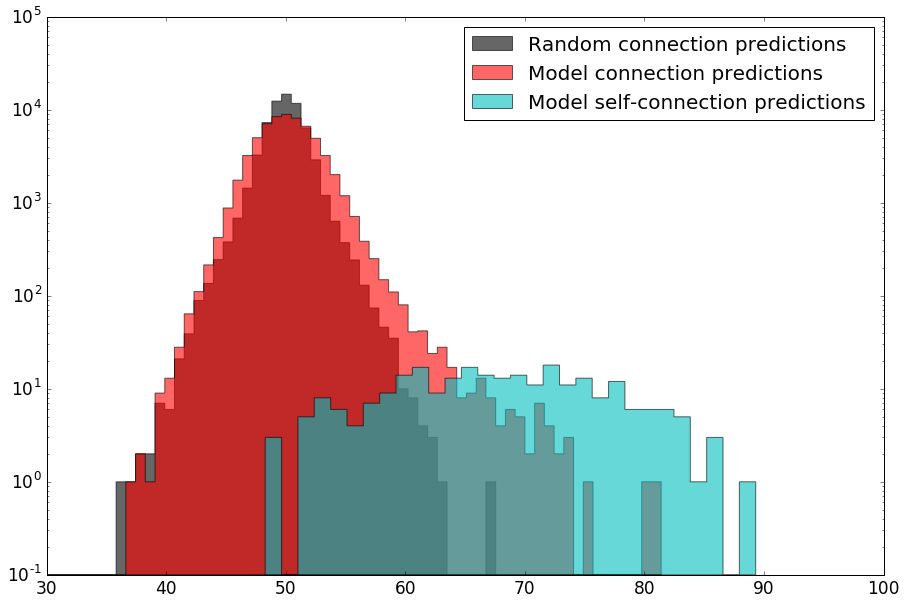

In [5]:
dirV1R = mPath + 'classiMat/perceptron/V1Classi/'
nmV1R  = 'classiRAND_255_30x3_prcptrRelu_10_2_2_10_cross'  

meanV1R, varV1R, matsV1R = meanvar(dirV1R,nmV1R);

bins = [0, 50, 100]
plt.figure(figsize = (15,10))

#plt.title('Control Weigth Distribution vs Predicted Weights Distribution')


np.fill_diagonal(meanV1,0)

hist, _, patches = plt.hist([meanV1,meanV1R ],
                            bins = 100, log = True, normed = False,
                            histtype='stepfilled', alpha = 0.6, color = ['r','k'],
                            label = ['Model connection predictions','Random connection predictions'])
plt.hist(diagV1,
         bins = 30, log = True, normed = False,
         histtype='stepfilled', alpha = 0.6, color = [ 'c'],
         label = ['Model self-connection predictions'])

#plt.xscale('log')
plt.xlim([30,100])


#patches[0][0].set_facecolor('r')
#patches[1][0].set_facecolor('k')

plt.legend(prop={'size':20})

plt.rcParams.update({'font.size': 17})

In [11]:
ZmeanV1    = (meanV1-np.mean(meanV1R))/np.mean(np.sqrt(varV1R))
#pVals     = stat.norm.(ZmeanV1)
pVals      = 1- scipy.special.ndtr(ZmeanV1)
probConnV1 = (1-pVals)*100
probConnV1 = meanV1

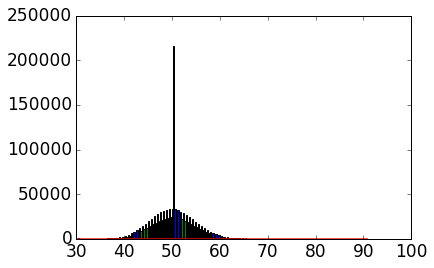

In [12]:
matsV1Stack  = np.hstack(np.hstack(matsV1))
matsV1RStack = np.hstack(np.hstack(matsV1R))

#standMatsV1Stack  = (matsV1Stack-np.mean(matsV1Stack))/np.std(matsV1Stack)
#standMatsV1RStack = (matsV1RStack-np.mean(matsV1RStack))/np.std(matsV1RStack)

#histAllV1 = plt.hist([standMatsV1Stack,standMatsV1RStack],100)
histAllV1 = plt.hist([matsV1Stack,matsV1RStack],100)


histRatio = histAllV1[0][0] / (histAllV1[0][0]+histAllV1[0][1])
#histRatio[0] =0 
plt.plot(histAllV1[1][:-1],histRatio.T)

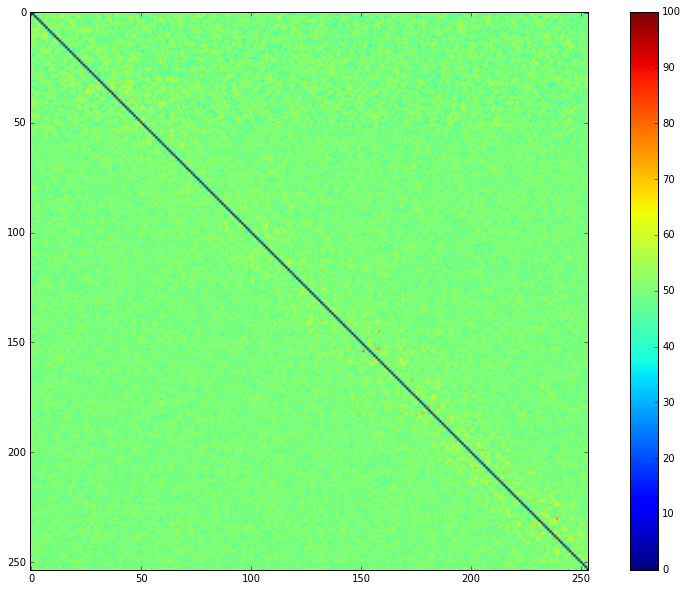

In [627]:
#probConnV1 = np.round(meanV1)
#for i in range(100):
#    probConnV1[probConnV1 == i] = histRatio[i]*100

plt.figure(figsize=(15,10))
plt.imshow(probConnV1)
plt.colorbar()
plt.clim([0,100])

## Correlation between Wheights and Activity Correlation

### Datasets Correlation

In [278]:
''' 
N         : Which neuron to use
allData   : all datasets stacked
visData   : all frames in visual stimulation condition
visOnly   : Only the frames containing stimuli in visual stim condition
spontData : all spontaneous datasets stacked 

'''
N = 254

#Full dataset
allDats = loadH5py(['01','02','03','04','05','06','07','08','09','10'], mPath+'data/optogenExp.h5')
allData = np.hstack(allDats['dataset'])[:N,:]
corrAll = np.corrcoef(allData)

#Visual stim dataset
visDats = loadH5py(['01'], mPath+'data/optogenExp.h5')
visData = visDats['dataset'][0][:N,:]
visFrm  = visDats['visFrame'][0]
corrVisAll = np.corrcoef(visData)

#Visual stim only when presentation
visDur = 121; #Number of frame for each stim

for f in visDats['visFrame'][0]:
    if f == visDats['visFrame'][0][0]:
        visOnly = visData[:N,f:f+visDur]
    else:
        visOnly = np.hstack([visOnly,visData[:N,f:f+visDur]])
corrVis = np.corrcoef(visOnly)

#Spontaneous datasets
spontDats = loadH5py(['02','05','06','07'], mPath+'data/optogenExp.h5')
spontData = np.hstack(spontDats['dataset'])[:N,:]
corrSpont = np.corrcoef(spontData)

### Classification and neuron correlation matrices

In [279]:
np.fill_diagonal(probConnV1,0)   ; np.fill_diagonal(corrAll,0)    ; np.fill_diagonal(corrVis,0) ; 
np.fill_diagonal(corrSpont,0); np.fill_diagonal(corrVisAll,0) ;  np.fill_diagonal(meanV1,0)

In [280]:
#Stacking classification matrix
probConnV1Stack= np.hstack(probConnV1)

#Stacking correlation matrices for plotting against classification matrix
corrAllStack = np.hstack( abs(corrAll) ) ; corrVisAllStack = np.hstack( abs(corrVisAll) )
corrVisStack = np.hstack( abs(corrVis) ) ; corrSpontStack  = np.hstack( abs(corrSpont)  )

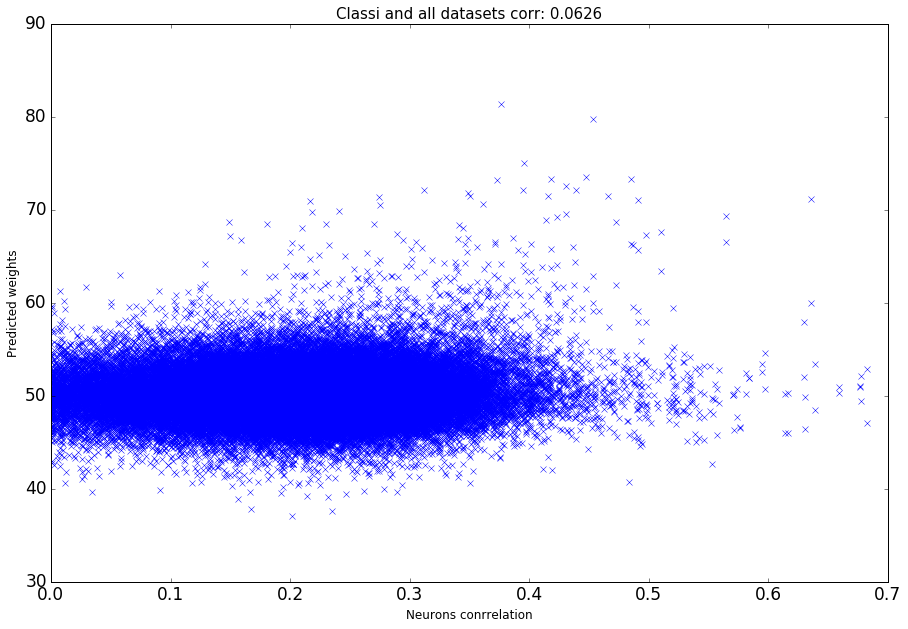

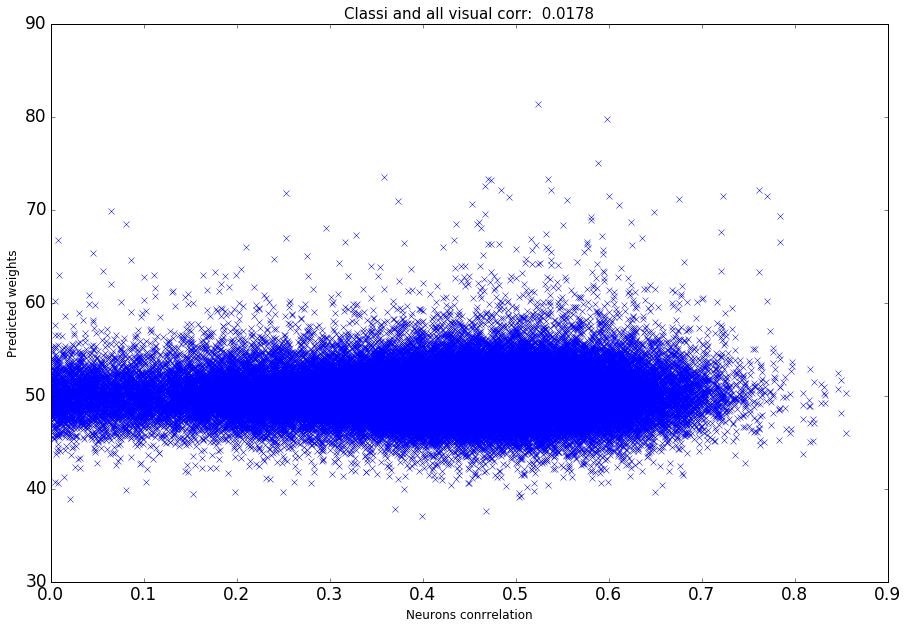

In [284]:
sigVal = 0
probCIdx = probConnV1Stack > sigVal

#All datasets
corrAllprobConnV1= np.corrcoef(corrAllStack[probCIdx], probConnV1Stack[probCIdx])

plotCorrClass( corrAllStack[probCIdx], probConnV1Stack[probCIdx],
               'Classi and all datasets corr: {:.4f}'.format(corrAllprobConnV1[1,0]) ) 

#Visu all frames 
corrVisAllprobConnV1 = np.corrcoef(corrVisAllStack[probCIdx], probConnV1Stack[probCIdx])
plotCorrClass( corrVisAllStack[probCIdx], probConnV1Stack[probCIdx], 
              'Classi and all visual corr:  {:.4f}'.format(corrVisAllprobConnV1[1,0])  ) 

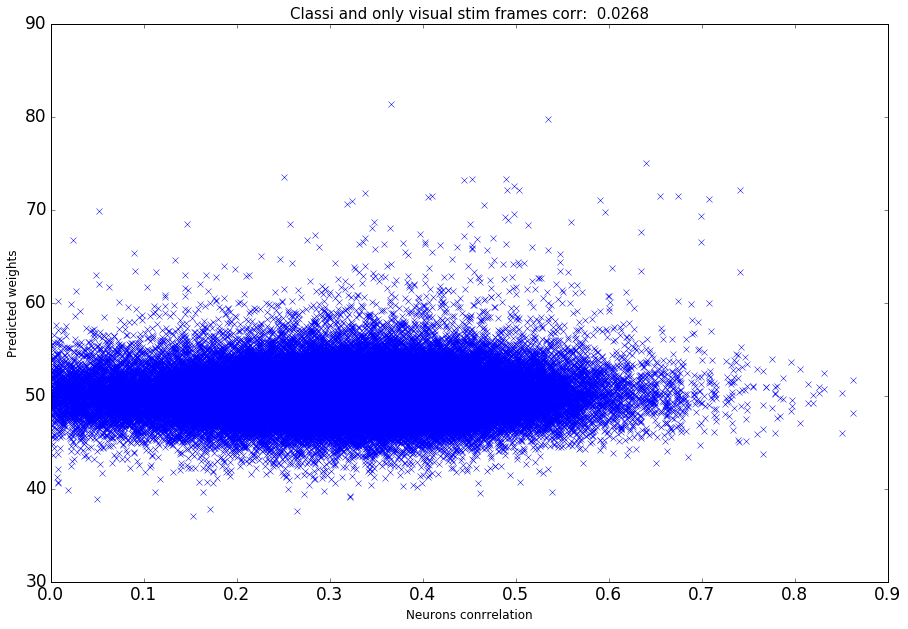

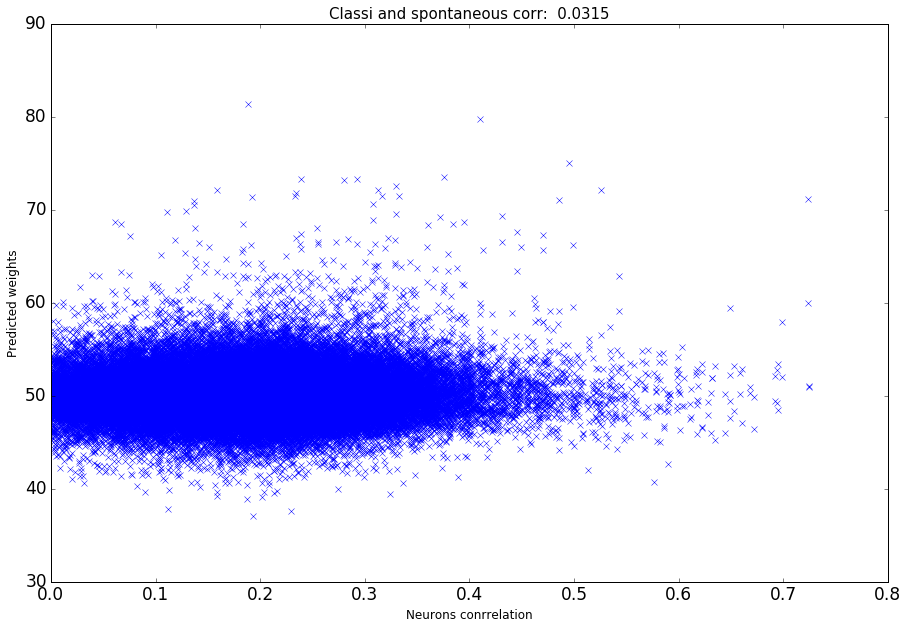

In [285]:
#Visu frames only
corrVisprobConnV1 = np.corrcoef(corrVisStack[probCIdx], probConnV1Stack[probCIdx])
plotCorrClass( corrVisStack[probCIdx],probConnV1Stack[probCIdx], 
              'Classi and only visual stim frames corr:  {:.4f}'.format(corrVisprobConnV1[1,0]) ) 

#Spontaneous data
corrSpontprobConnV1 = np.corrcoef(corrSpontStack[probCIdx], probConnV1Stack[probCIdx])
plotCorrClass( corrSpontStack[probCIdx], probConnV1Stack[probCIdx],
              'Classi and spontaneous corr:  {:.4f}'.format(corrSpontprobConnV1[1,0]) )

In [324]:
#Visual stim orientation preference
nf       = 241 #Number of frame for each visual stim (8 seconds)
stimResp = meanSTA(visData, visFrm)[1]

#Significantly tuned cells
sigVal = 0.05
niters = 1000
tunedCells, notTunedCells = bootstrapSigPref(visData, visFrm, sigVal =sigVal, niters = niters)

#Correlation between tuning of significantly tuned cells
corrPref     = np.corrcoef(stimResp[:,tunedCells].T) ; np.fill_diagonal(corrPref,0)
#corrPref     = np.corrcoef(stimResp[:,:].T) ; np.fill_diagonal(corrPref,0)
corrPrefStack= np.hstack( abs(corrPref) ) ; 

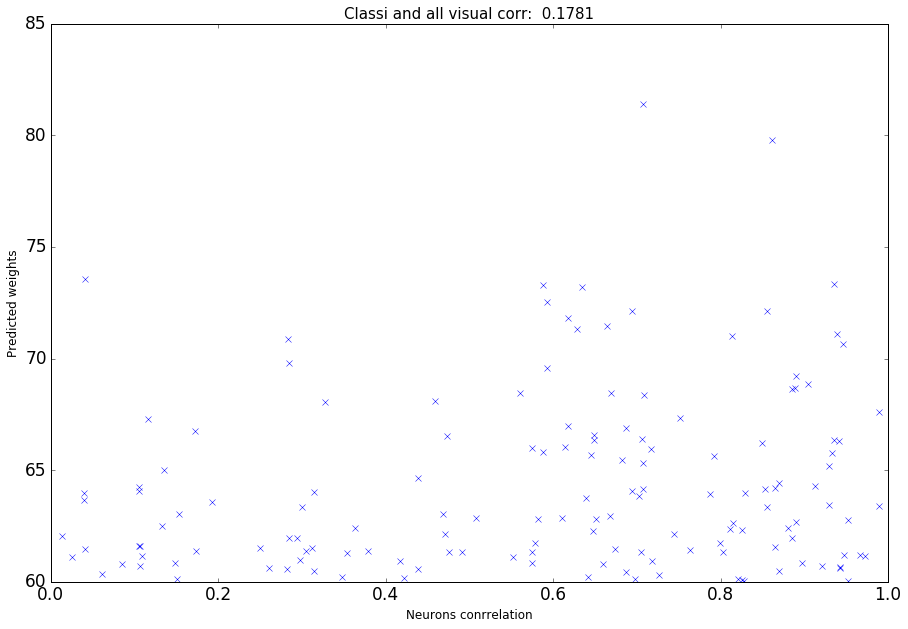

In [339]:
sigScore= 60

probConnV1TunedStack= np.hstack(probConnV1[tunedCells,:][:,tunedCells])

#Idx of classification scores above sigscore
classiIdx = probConnV1TunedStack > sigScore

#Visu all frames 
corrPrefprobConnV1 = np.corrcoef(corrPrefStack[classiIdx],
                                 probConnV1TunedStack[classiIdx])

plotCorrClass( corrPrefStack[classiIdx],
               probConnV1TunedStack[classiIdx], 
              'Classi and all visual corr:  {:.4f}'.format(corrPrefprobConnV1[1,0])  )

### Ratio of high predictions with respect to correlation

In [669]:
import matplotlib.colors as mcol
import matplotlib.cm as cm

nbins = 10

#Defining colors
cm1   = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])
cnorm = mcol.Normalize(vmin = 0, vmax = nbins )
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])


#Calculating bins for histogram
corr  = corrPrefStack # corrVisAllStack[probCIdx]
probC = probConnV1TunedStack # probConnV1Stack[probCIdx]

p = 1/nbins


bins = [[None]*nbins]*100
for l in range(1):
    for i in range(0,nbins):
        if not i == nbins-1:
            idx = ( corr >= p*i ) & (corr < p*(i+1))
        else :
            idx = ( corr >= p*i )
        bins[l][i] = probC[idx]

    #bins[l,:] = bins[l,:]/bins[l,:].max()
    
#plt.plot(bins)

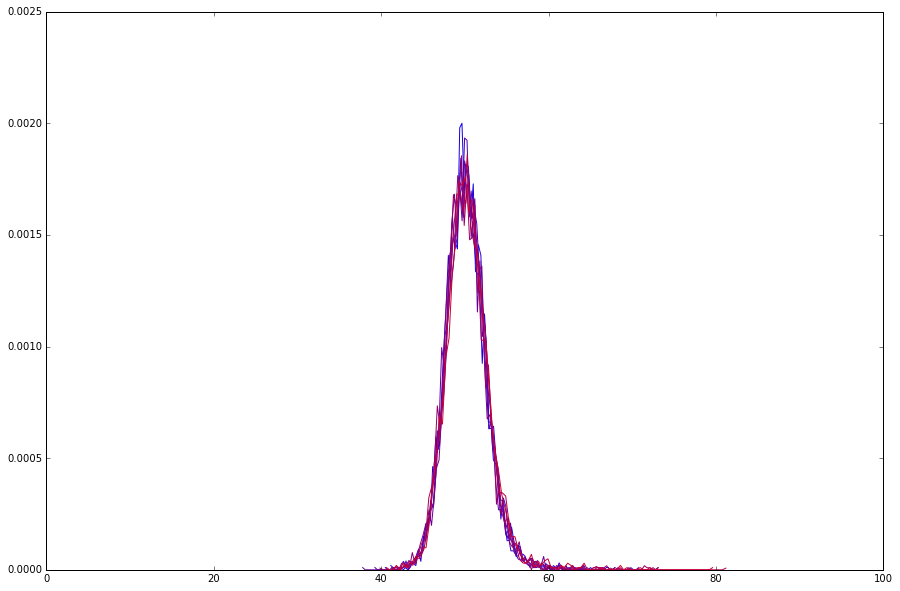

In [670]:
binsE = [None]*nbins
binC  = [None]*nbins
y     = [None]*nbins

plt.figure(figsize = (15,10))
for i in range(1,nbins-1):
    y[i],binsE[i] = np.histogram(bins[90][i],bins=100, normed = True)
    binC[i]    = 0.5*(binsE[i][1:]+binsE[i][:-1])
    y[i] = y[i]/len(y[i])
    plt.plot(binC[i],y[i], color= cpick.to_rgba(i))

#plt.legend(['[0.0 , 0.1[','[0.1 , 0.2[','[0.2 , 0.3[','[0.3 , 0.4[','[0.4 , 0.5[',
#            '[0.5 , 0.6[','[0.6 , 0.7[','[0.7 , 0.8[','[0.8 , 0.9[','[0.9 , 1.0]'])
plt.xlim([0,100])
plt.show()


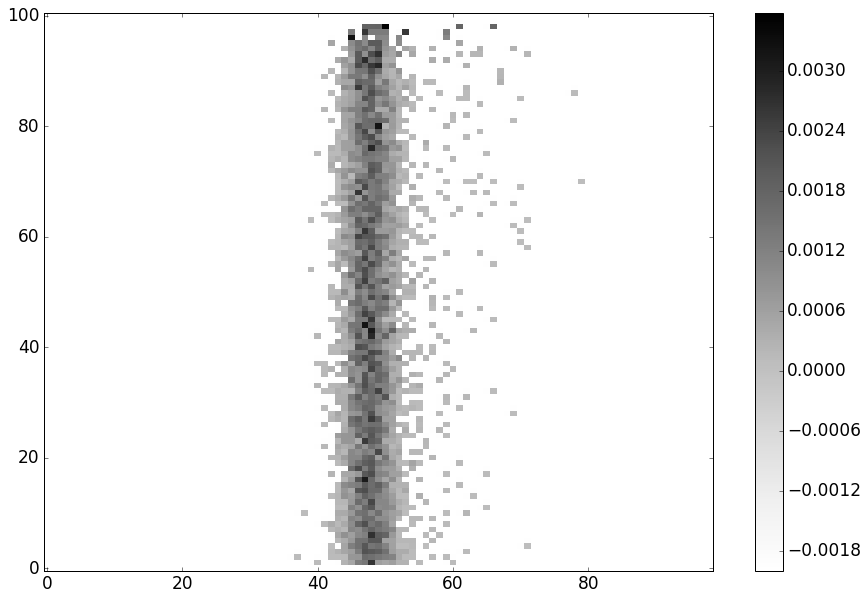

In [345]:
Y = np.zeros([nbins+1,101])
for i in range(len(binC)):
    if not binC[i] is None:
        idx = np.int32(np.round(binC[i]))
        Y[i,idx] = y[i]

Y[Y==0] = -0.002
plt.figure(figsize = (15,10))
plt.imshow(Y[:,2:], interpolation = 'None', aspect = 'auto', cmap = 'Greys')
plt.gca().invert_yaxis()
plt.colorbar()

In [746]:
#Calculating bins for counter
bins = np.zeros([100,10])
for l in range(100):
    for i in range(10):
        idx         = ( corr >= 0.1*i ) & (corr < 0.1*(i+1))
        probConSamp = probC[idx] 
        bins[l][i] = sum(probConSamp>l)/sum(idx)
        
        #bins[l,i] = np.mean(probConSamp)
        #bins[l,:] = bins[l,:]/bins[l,:].max()
        
        
#Calculating standart error with folds
tresh = 55 #Classification accuracy threshold 

binsSamp = np.zeros([10,10])
for s in range(10):
    
    probCS= np.hstack(matsV1R[tunedCells,:][:,tunedCells,s])
    
    for i in range(10):
        idx         = ( corr >= 0.1*i ) & (corr < 0.1*(i+1))
        probConSamp = probCS[idx] 
        binsSamp[s][i] = sum(probConSamp>tresh)/sum(idx)
        
stdEr = np.std(binsSamp, axis = 0)/np.sqrt(10)

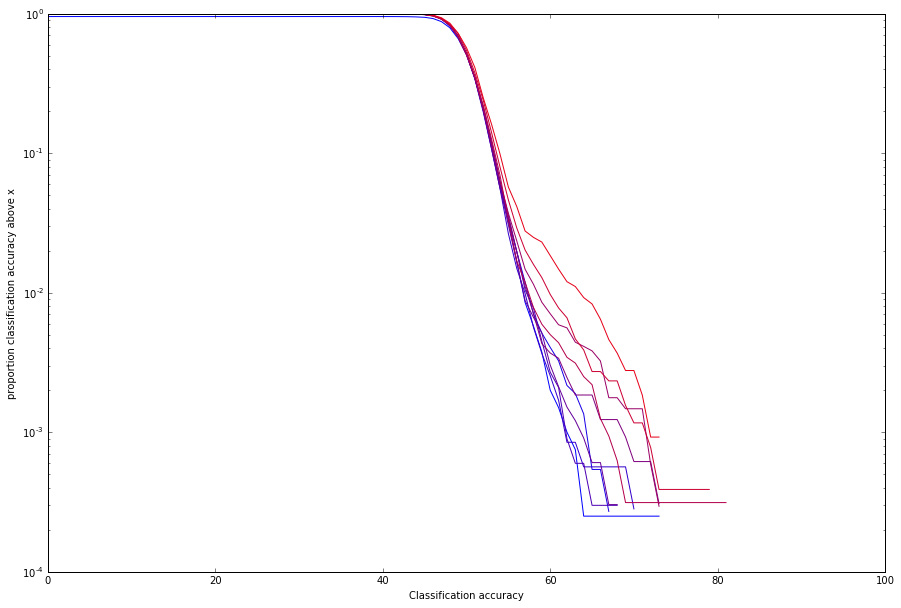

In [661]:
nbins = 10

#Defining colors
cm1   = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b","r"])
cnorm = mcol.Normalize(vmin = 0, vmax = nbins )
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])


plt.figure(figsize = (15,10))

for i in range(10):
    plt.semilogy(bins[:,i],color= cpick.to_rgba(i)) 
    
plt.xlabel('Classification accuracy')
plt.ylabel('proportion classification accuracy above x')

<Container object of 7 artists>

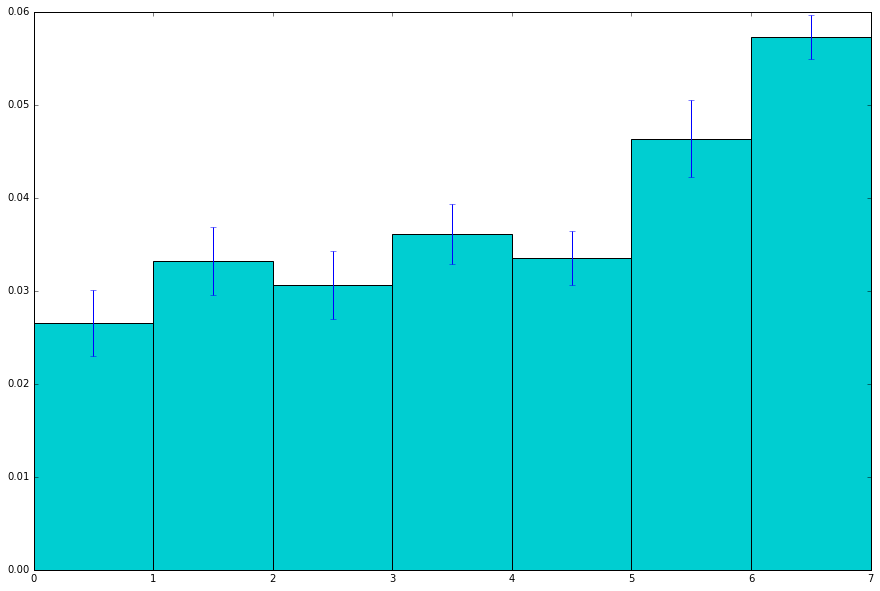

In [747]:
plt.figure(figsize = (15,10))

binni = bins[55][[2,3,4,5,7,8,9]]
stdErri = stdEr[[2,3,4,5,7,8,9]]

plt.bar(np.arange(7),binni, yerr = stdErri*1.96,  width = 1, color = 'darkturquoise')

# Block simulation data

In [748]:
#Loading data
Dblock = np.load(mPath+ 'data/stblockOPTO_30Hz_y097.npy').all()

## Connectivity Reconstruction

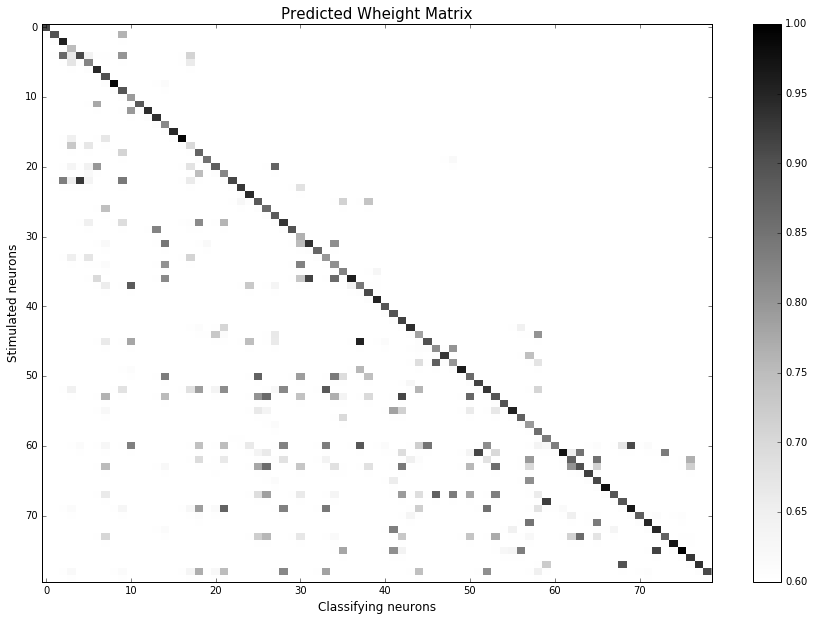

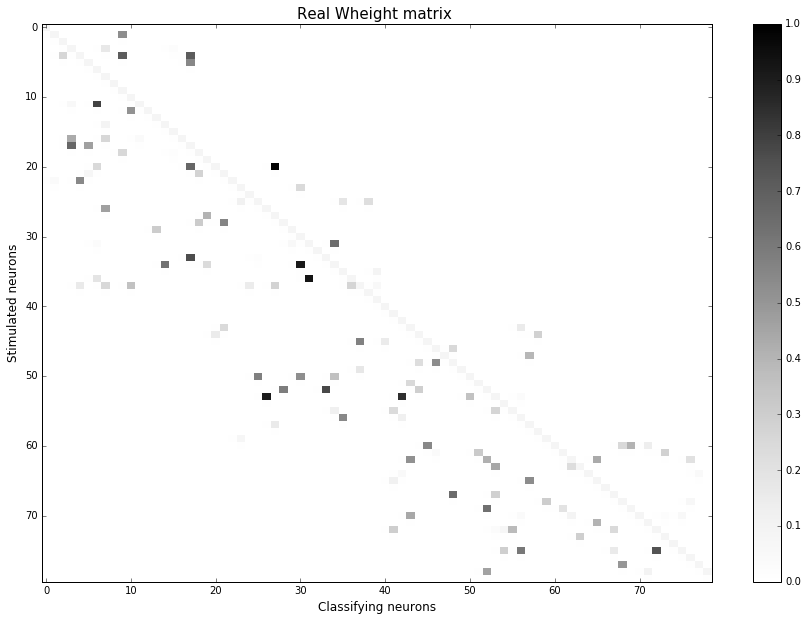

In [749]:
dirSim = mPath+'classiMat/perceptron/simulClassi/'
nmSim  = 'simul_30Hz_y97_prcptrRelu_3_0_0_3'  

meanSim, varSim, matsSim = meanvar(dirSim,nmSim)
#np.fill_diagonal(meanSim,0)

plotClassMat(meanSim, 'Predicted Wheight Matrix', clim = [.6,1], norm = True)
#plotClassMat(varV1, 'Classification Matrix Variance')
plotClassMat(abs(Dblock['W'].T), 'Real Wheight matrix ', norm = True)

## Correlation

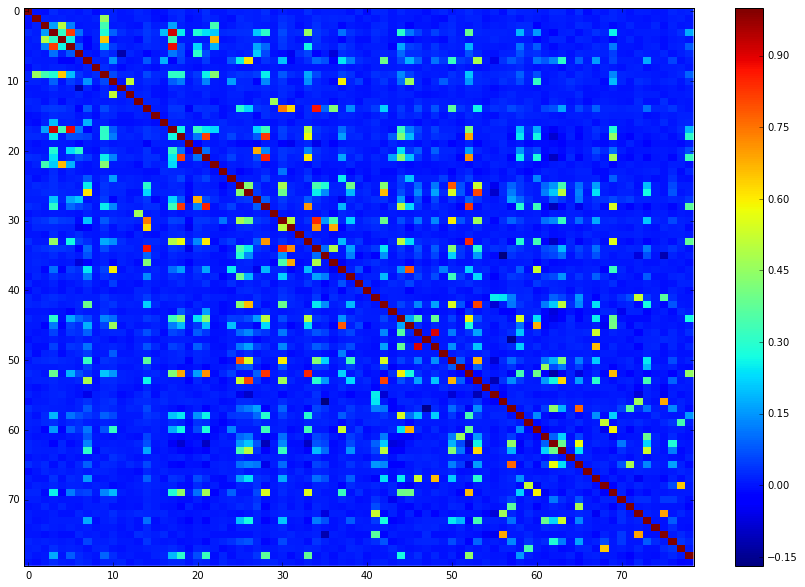

In [750]:
corrSim = np.corrcoef(Dblock['dataset'])
plt.figure(figsize = (15,10))
plt.imshow(corrSim[:,:-1], aspect = 'auto', interpolation = 'None')
plt.colorbar()

### Recall vs Precision plot

/groups/turaga/home/castonguayp/anaconda3/envs/tfcpu/lib/python3.5/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in long_scalars
/groups/turaga/home/castonguayp/anaconda3/envs/tfcpu/lib/python3.5/site-packages/ipykernel/__main__.py:56: RuntimeWarning: invalid value encountered in long_scalars


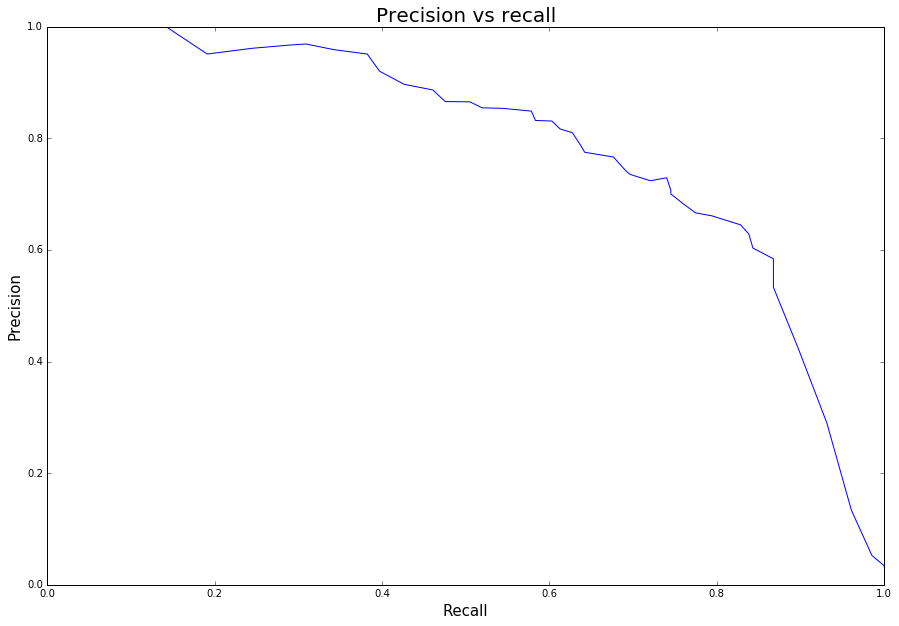

In [742]:
M = np.zeros([2,100])
for a in range(1,101):
    m = classMetrics(abs(Dblock['W'].T), meanSim, a) #Metrics give treshold a
    
    M[0,a-1] = m['recall']    #Recall storage
    M[1,a-1] = m['precision'] #Recall storage
    
plt.figure(figsize = (15,10))
plt.plot(M[0,:],M[1,:])
plt.xlabel('Recall', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)
plt.title('Precision vs recall', fontsize = 20)

### Classification metrics values

In [733]:
metrics = classMetrics(abs(Dblock['W'].T),meanSim,60)

print('True  pos:    {}'.format(metrics['truePos']))
print('False pos:    {}'.format(metrics['falsePos']))
print('True  neg:    {}'.format(metrics['trueNeg']))
print('False neg:    {}\n'.format(metrics['falseNeg']))

print('Recall:       {:.3f} %'.format(metrics['recall']*100))
print('Precis:       {:.3f} %'.format(metrics['precision']*100))
print('Neg Pred Val: {:.3f} %'.format(metrics['negPredVal']*100))
print('Acc:          {:.3f} %'.format(metrics['acc']*100))


True  pos:    158
False pos:    79
True  neg:    6117
False neg:    46

Recall:       77.451 %
Precis:       66.667 %
Neg Pred Val: 99.254 %
Acc:          82.960 %
